In [1]:
import sys
sys.path.append('..')
from src.kitti import *
from src.boundingbox import format_yolo_output
import numpy as np
import cv2
import json
%matplotlib inline

In [2]:
IMAGES_LOCATION = "/data/urbinn/datasets/kitti/sequences/00/image_2/"
YOLO_LOCATION = "/data/urbinn/darknet/output/seq00_image02/objects.json"

yolo_output = json.load(open(YOLO_LOCATION))

def imgread(file):
    img = cv2.imread(file)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
class BoundingBox:
    def __init__(self, classification):
        name, confidence, coords = classification
        cx, cy, width, height = coords
        
        self.object_name = name
        self.cx = cx
        self.cy = cy
        self.width = width
        self.height = height
        self.calculate_bounds()

    def calculate_bounds(self):
        #         min,                            max
        self.y = (int(self.cy - self.height / 2), int(self.cy + self.height / 2))
        self.x = (int(self.cx - self.width / 2), int(self.cx + self.width / 2))
    
    def contains(self, point):
        return (self.x[0] <= point.cx <= self.x[0] + self.width and
            self.y[0] <= point.cy <= self.y[0] + self.height)
    
    def draw(self, img, show_classifier = False, text_color=(0, 255, 0), color=(255, 0, 0)):
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.rectangle(img, (self.x[0], self.y[0]), (self.x[1], self.y[1]), color)   
        
        if show_classifier:
            cv2.putText(img, self.object_name, (self.x[0], self.y[0]), font, 0.4, text_color, 0)
            
    def debug(self):
        print("object: {} cx: {} cy: {} width: {} height: {}")

In [4]:
def format_output(json, level = 1):
    if (level == 1):
        return format_per_image(json)
    else:
        classified_objects = []
        for img in json:
            classified_objects.append(format_per_image(img))
        
        return classified_objects

def format_per_image(json):
    classified_objects = []
    image_name = json[0]
    
    for classification in json:
        # Filter out image name
        if (isinstance(classification, list)):
            classified_objects.append(BoundingBox(classification))
            
    return (image_name, classified_objects)

def draw_all_classifications_with_points(json):
    classifications = format_output(json)
    image_path = "{}{}".format(IMAGES_LOCATION, classifications[0])
    img = imgread(image_path)
    
    for clas in classifications[1]:
        clas.draw(img, show_classifier = True)
    
    frame = Frame(image_path)
    observations = frame.get_observations()
    points = []

    # TODO: observations <-> classification name
    for obs in observations:
        x, y = observations[0].cx, observations[0].cy
        for clas in classifications[1]:
            if clas.contains(obs):
                points.append(obs)
    
    show(draw_observations(points, img))

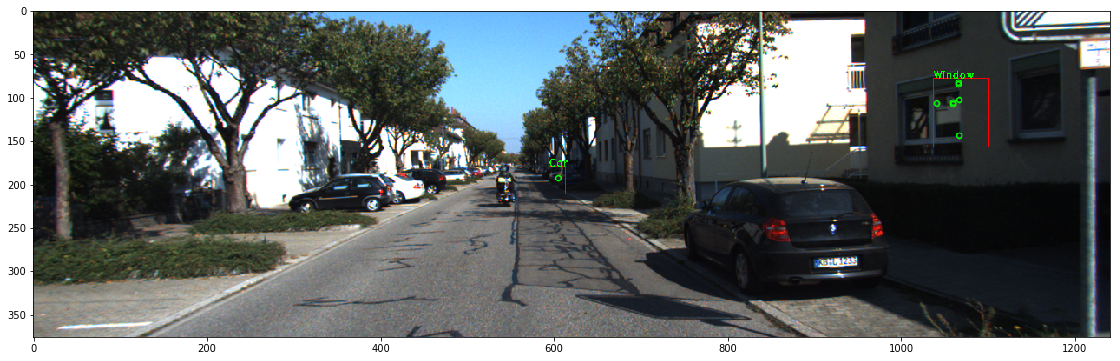

In [5]:
draw_all_classifications_with_points(yolo_output[0])